In [3]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import cross_val_score
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import settings

In [4]:
dietary_data_path = f'{settings.output_folder}diet.csv'
targets_path = f'{settings.raw_data_folder}control/regression_targets.csv'

In [6]:
food_data = pd.read_csv(dietary_data_path)
food_data = food_data[food_data.columns[2:]]
food_data.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,...,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Confirmed,Deaths,Recovered,Vegetables,Country
0,0.000030,0.326636,0.223147,0.0,0.733914,0.132792,0.000638,0.148116,0.133538,0.025586,...,0.0,0.093136,0.113588,0.663569,0.246708,0.013626,0.033360,0.013648,0.320304,Afghanistan
1,0.095202,0.741183,0.154200,0.0,0.146948,0.460113,0.022935,0.274058,0.283455,0.039222,...,0.0,0.145522,0.221400,0.226743,0.149209,0.285071,0.274778,0.198303,0.592018,Albania
2,0.011670,0.274016,0.034457,0.0,0.378697,0.313765,0.024193,0.237088,0.103129,0.076753,...,0.0,0.176586,0.160859,0.745976,0.556105,0.023500,0.035368,0.018537,0.585138,Algeria
3,0.251279,0.199301,0.053595,0.0,0.288345,0.022781,0.184776,0.189200,0.290182,0.051748,...,0.0,0.130798,0.004750,0.764589,0.390946,0.005897,0.007877,0.006284,0.078466,Angola
4,0.226478,0.656624,0.171604,0.0,0.131001,0.118321,0.346861,0.356505,0.621373,0.217600,...,0.0,0.318216,0.043980,0.311472,0.346539,0.028206,0.038521,0.021108,0.249017,Antigua and Barbuda


In [7]:
targets = pd.read_csv(targets_path)

In [ ]:
food_data.drop(['Deaths', 'Recovered', 'Confirmed'], axis=1, inplace=True)

In [ ]:
food_data = food_data.merge(targets, on='Country', how='inner')

In [ ]:
food_data

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,Milk - Excluding Butter,Offals,Oilcrops,Pulses,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Vegetables,Country,Deaths,Confirmed,Recovered
0,0.000030,0.326636,0.223147,0.000000,0.733914,0.132792,0.000638,0.148116,0.133538,0.025586,0.353124,0.250286,0.018133,0.074582,0.090683,0.008648,0.101278,0.000000,0.093136,0.113588,0.663569,0.246708,0.320304,Afghanistan,0.006186,0.142134,0.123374
1,0.095202,0.741183,0.154200,0.000000,0.146948,0.460113,0.022935,0.274058,0.283455,0.039222,0.917774,0.307851,0.095765,0.072650,0.000402,0.036580,0.119830,0.000000,0.145522,0.221400,0.226743,0.149209,0.592018,Albania,0.050951,2.967301,1.792636
2,0.011670,0.274016,0.034457,0.000000,0.378697,0.313765,0.024193,0.237088,0.103129,0.076753,0.402251,0.097426,0.030560,0.127221,0.080131,0.086139,0.109900,0.000000,0.176586,0.160859,0.745976,0.556105,0.585138,Algeria,0.006558,0.244897,0.167572
3,0.251279,0.199301,0.053595,0.000000,0.288345,0.022781,0.184776,0.189200,0.290182,0.051748,0.044997,0.158570,0.090937,0.168936,0.001731,0.534029,0.030582,0.000000,0.130798,0.004750,0.764589,0.390946,0.078466,Angola,0.001461,0.061687,0.056808
4,0.185313,0.713814,0.173578,0.000000,0.161196,0.548327,0.037607,0.152709,0.821974,0.000000,0.373834,0.298039,0.000463,0.013133,0.017223,0.063410,0.175876,0.000000,0.335253,0.028820,0.278729,0.429676,0.189416,Argentina,0.108227,4.356147,3.905192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0.110921,0.381194,0.085436,0.000000,0.294196,0.187844,0.090223,0.242472,0.321285,0.018274,0.336548,0.207525,0.001773,0.078660,0.000453,0.059798,0.056898,0.000000,0.375505,0.001428,0.686766,0.695760,0.178414,Venezuela (Bolivarian Republic of),0.004287,0.452585,0.424399
150,0.077855,0.536682,0.165005,0.000834,0.432653,0.194973,0.221331,0.170024,0.751990,0.015410,0.034182,0.395196,0.131814,0.049178,0.298923,0.020812,0.099123,0.241974,0.085882,0.297618,0.331252,0.041308,0.601534,Vietnam,0.000036,0.002063,0.001526
151,0.000789,0.162025,0.069646,0.000000,0.772265,0.127352,0.046031,0.127433,0.252005,0.050883,0.069233,0.239016,0.015113,0.198082,0.043443,0.011286,0.112990,0.000000,0.405366,0.011577,0.837426,0.460589,0.127776,Yemen,0.002062,0.007131,0.004788
152,0.468885,0.131752,0.069386,0.000000,0.743871,0.163937,0.145513,0.012698,0.155113,0.049938,0.061233,0.227002,0.266735,0.039638,0.063852,0.184374,0.025747,0.000000,0.113278,0.001367,0.887470,0.273236,0.141407,Zambia,0.004564,0.334133,0.290524


In [ ]:
label_values = ['Deaths', 'Recovered', 'Confirmed']
features_food = food_data.columns.drop(label_values)
features_food = features_food.drop(['Country'])
X_food = food_data[features_food]
Y_food = food_data[label_values]

In [ ]:
PARAMS = {
    'max_depth': [2, 3, 5, 7],
    'min_child_weight': [2, 3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1],
    'n_estimators': [75, 100, 150, 200]
}

In [ ]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [ ]:
def rfecv_shap_algorithm(estimator, X, Y, algorithm, step=1, score='neg_median_absolute_error'):
  shap_elimination = ShapRFECV(clf=estimator, step=step, cv=7, scoring=score, n_jobs=-1)
  shap_report = shap_elimination.fit_compute(X, Y)
  best_features_rfe_shap = shap_report[shap_report['val_metric_mean'] == shap_report['val_metric_mean'].max()]
  features_shap = list(best_features_rfe_shap['features_set'].values[0])
  features_shap_cv = {}
  features_shap_cv['algorithm'] = 'rfe - measure shap ' + algorithm
  features_shap_cv['selected_features'] = features_shap
  features_shap_cv['number_of_features'] = len(features_shap)
  features_shap_cv['neg_mae_score_cv'] = shap_report['val_metric_mean'].max()
  feat_shap = pd.DataFrame(features_shap_cv)
  feat_shap.to_csv(f'{settings.features_folder}selected_features_rfe_shap_' + algorithm + '.csv', index=False)
  return feat_shap

In [ ]:
xgboost_best_food_params, xgboost_best_food_score = hyper_parameter_search(X_food, Y_food['Deaths'], PARAMS)

[21:36:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(f'best parameters: {xgboost_best_food_params}')
print(f'score: {xgboost_best_food_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 200}
score: -0.026233139002078486


In [ ]:
xgb_food = XGBRegressor(gamma = xgboost_best_food_params['gamma'], 
                        learning_rate = xgboost_best_food_params['learning_rate'],
                        max_depth = xgboost_best_food_params['max_depth'],
                        min_child_weight = xgboost_best_food_params['min_child_weight'],
                        n_estimators = xgboost_best_food_params['n_estimators'], 
                        random_state=14)

In [ ]:
rfecv_xgb_food = rfecv_shap_algorithm(xgb_food, X_food, Y_food['Deaths'], 'food')

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [ ]:
rfecv_xgb_food

,algorithm,selected_features,number_of_features,neg_mae_score_cv
0,rfe - measure shap food,Animal fats,7,-0.016
1,rfe - measure shap food,Milk - Excluding Butter,7,-0.016
2,rfe - measure shap food,Eggs,7,-0.016
3,rfe - measure shap food,"Fish, Seafood",7,-0.016
4,rfe - measure shap food,Fruits - Excluding Wine,7,-0.016
5,rfe - measure shap food,Animal Products,7,-0.016
6,rfe - measure shap food,Alcoholic Beverages,7,-0.016


In [ ]:
selected_features_food = rfecv_xgb_food['selected_features'].values

<h3>Shap feature importnace</h3>

In [ ]:
X_train_food, X_test_food, Y_train_food, Y_test_food = train_test_split(
    X_food[selected_features_food],
    Y_food,
    test_size = 0.15,
)

In [ ]:
xgb_food.fit(X_train_food, Y_train_food['Deaths'])

[21:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=14,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

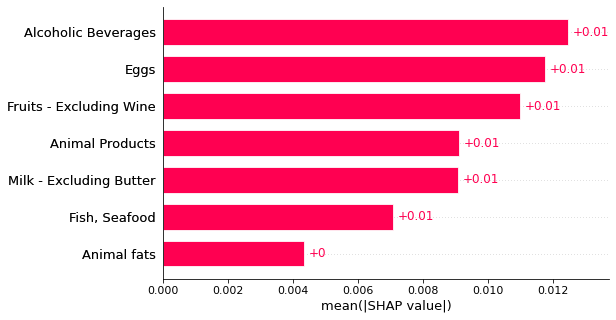

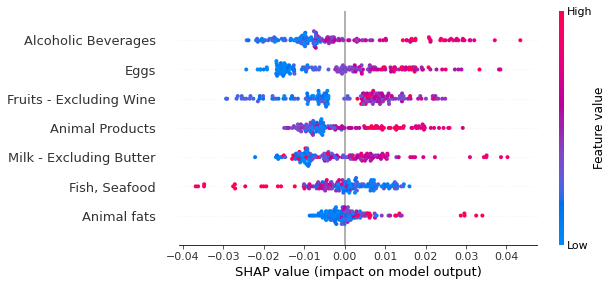

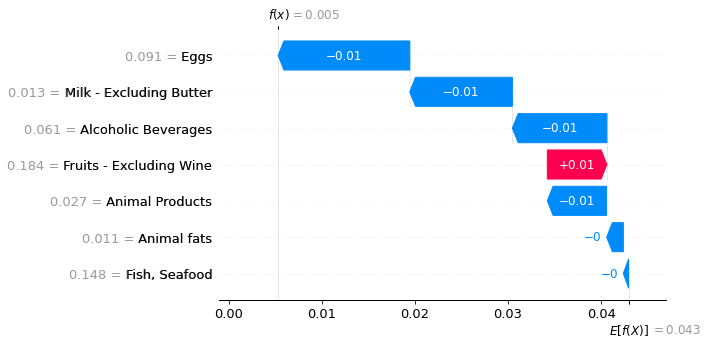

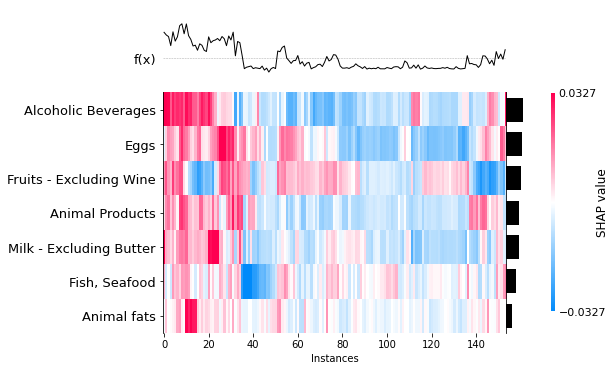

In [ ]:
expl = shap.Explainer(xgb_food, X_food[selected_features_food])
shap_values = expl(X_food[selected_features_food])
shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.waterfall(shap_values[30])
shap.plots.heatmap(shap_values, max_display=20)